# Main analysis file

We load up one large dataframe consisting of all simulation sweeps and curves, produced by [src/get_all_data.py](../get_all_data.py).

In [1]:
import hydra
import torch

import pandas as pd
import plotnine as pn

from hydra.core.global_hydra import GlobalHydra

# Lets us import ibsg modules
import sys
sys.path.append("/Users/nathanielimel/uci/projects/ibsg/src")

from game.game import Game

## Load main dataframe

In [2]:
all_data_fp = "../../analysis_data/all_data.csv"

In [3]:
df = pd.read_csv(all_data_fp)
df

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_27271/2865108240.py:1: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.


,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,prior,num_signals,distance,discriminative_need_gamma,meaning_dist_gamma,dynamics,imprecise_imitation_gamma,population_init_gamma,seed,ib_bound_function
0,0.302817,0.285931,1.626097,10.196382,0.026481,-0.009173,0.749013,0.0,simulation,NaN,...,-8,10,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,NaN
1,2.704773,1.499383,0.412644,9.724241,NaN,NaN,NaN,1.0,trajectory,0.0,...,-8,10,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,NaN
2,0.203795,0.189977,1.722051,11.818519,NaN,NaN,NaN,1.0,trajectory,1.0,...,-8,10,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,NaN
3,0.151592,0.142945,1.769083,12.727127,NaN,NaN,NaN,1.0,trajectory,2.0,...,-8,10,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,NaN
4,0.151410,0.143119,1.768909,12.660234,NaN,NaN,NaN,1.0,trajectory,3.0,...,-8,10,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160763,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,-8,100,squared_dist,NaN,0,NaN,NaN,NaN,NaN,embo
160764,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,-8,100,squared_dist,NaN,0,NaN,NaN,NaN,NaN,embo
160765,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,-8,100,squared_dist,NaN,0,NaN,NaN,NaN,NaN,embo
160766,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,-8,100,squared_dist,NaN,0,NaN,NaN,NaN,NaN,embo


## Set parameters for one theoretical bound

Using hydra compose overrides.

In [4]:
overrides = [
    # "game.universe=c1",

    # "game.universe=100",
    # "game.num_signals=100",

    # "game.universe=2ball_300",
    # "game.num_signals=300",

] # n.b.: do not include multirun overrides, we will filter from columns in the dataframe.

# Global initialization
GlobalHydra.instance().clear() # from previous runs of notebook
hydra.initialize(version_base=None, config_path="../../conf")
config = hydra.compose(
    config_name="config",
    overrides=overrides,
)

curve_metadata = config.game

#### Meaning distributions

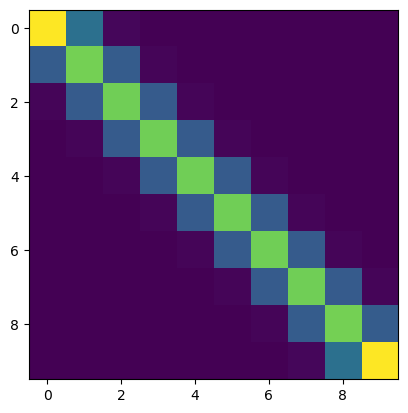

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

game = Game.from_hydra(config, cwd="/Users/nathanielimel/uci/projects/ibsg/data")
plt.imshow(game.meaning_dists)

#### helper function for subsetting

In [6]:
def get_df_subsetted_by_bound(df: pd.DataFrame, curve_metadata) -> pd.DataFrame:
    """Return a subset of the data consistent with the specifications in the curve_metadata config."""

    # See src/get_all_data.py
    universe = df["universe"].astype(str) == str(curve_metadata.universe)
    prior = df["prior"].astype(str) == str(curve_metadata.prior)
    num_signals = df["num_signals"] == curve_metadata.num_signals # this is prob not necessary
    distance = df["distance"] == curve_metadata.distance

    meaning_dist_gamma = df["meaning_dist_gamma"] == curve_metadata.meaning_dist_gamma

    bound_func = df["ib_bound_function"].isin([curve_metadata.ib_bound_function, torch.nan]) # check for 'embo', 'homebuilt' for curves, nan for all simulations since those are curve agnostic.

    df_subsetted = df[universe & prior & num_signals & num_signals & distance & meaning_dist_gamma & bound_func]

    return df_subsetted

### Subset dataframes for plotting

In [7]:
# visualize the curve!
df = get_df_subsetted_by_bound(df, curve_metadata)
df

,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,prior,num_signals,distance,discriminative_need_gamma,meaning_dist_gamma,dynamics,imprecise_imitation_gamma,population_init_gamma,seed,ib_bound_function
0,0.302817,0.285931,1.626097,10.196382,0.026481,-0.009173,0.749013,0.0,simulation,NaN,...,-8,10,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,NaN
1,2.704773,1.499383,0.412644,9.724241,NaN,NaN,NaN,1.0,trajectory,0.0,...,-8,10,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,NaN
2,0.203795,0.189977,1.722051,11.818519,NaN,NaN,NaN,1.0,trajectory,1.0,...,-8,10,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,NaN
3,0.151592,0.142945,1.769083,12.727127,NaN,NaN,NaN,1.0,trajectory,2.0,...,-8,10,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,NaN
4,0.151410,0.143119,1.768909,12.660234,NaN,NaN,NaN,1.0,trajectory,3.0,...,-8,10,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156022,3.321928,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,-8,10,squared_dist,NaN,0,NaN,NaN,NaN,NaN,embo
156023,3.321928,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,-8,10,squared_dist,NaN,0,NaN,NaN,NaN,NaN,embo
156024,3.321928,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,-8,10,squared_dist,NaN,0,NaN,NaN,NaN,NaN,embo
156025,3.321928,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,-8,10,squared_dist,NaN,0,NaN,NaN,NaN,NaN,embo


In [8]:
df_final_points = df[df["point_type"] == "simulation"]
df_curve_points = df[df["point_type"] == "ib_bound"]

### Plot

#### Trade-offs

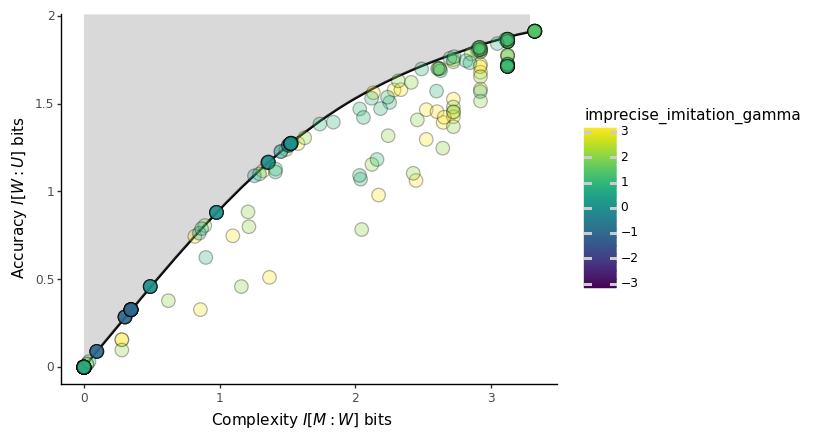

In [9]:
plot = (
    # Set data and the axes
    pn.ggplot(
        data=df_curve_points, mapping=pn.aes(x="complexity", y="accuracy")
    )  
    + pn.geom_line(size=1) # IB curve
    # + pn.geom_point(size=1)
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="accuracy",
        ymax=torch.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_point( # emergent langs
        data=df_final_points,
        mapping=pn.aes(
            # fill="discriminative_need_gamma",
            fill="imprecise_imitation_gamma",
            # fill="population_init_gamma",
            ),
        alpha=0.3,
        size=5,
    )        
    + pn.xlab("Complexity $I[M:W]$ bits")
    + pn.ylab("Accuracy $I[W:U]$ bits")
    + pn.theme_classic()
)
print(plot)

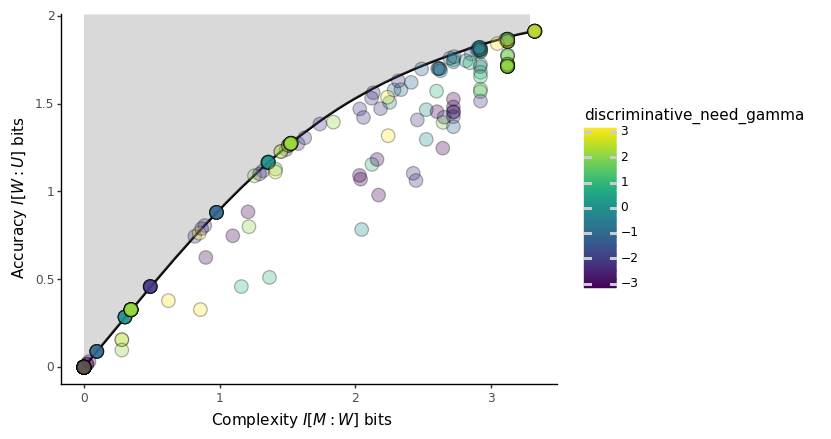

<ggplot: (689810961)>

In [136]:
# some scratch 
def plot_pressure_limits(pressure: str, pressure_limit: float) -> pn.ggplot:
    return (
        # Set data and the axes
        pn.ggplot(
            data=df_curve_points, mapping=pn.aes(x="complexity", y="accuracy")
        )  
        + pn.geom_line(size=1) # IB curve
        # + pn.geom_point(size=1)
        + pn.geom_ribbon(
        mapping=pn.aes(
            x="complexity",
            ymin="accuracy",
            ymax=torch.inf,
            ),
            fill="gray",
            alpha=0.3,
        )
        + pn.geom_point( # emergent langs
            data=df_final_points[df_final_points[pressure] <= pressure_limit],
            mapping=pn.aes(
                fill = pressure,
                ),
            alpha=0.3,
            size=5,
        )        
        + pn.xlab("Complexity $I[M:W]$ bits")
        + pn.ylab("Accuracy $I[W:U]$ bits")
        + pn.theme_classic()
    )
plot_pressure_limits(
    pressure="discriminative_need_gamma",
    pressure_limit=3,
)

### 3D plot of parameterspace

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_27271/3274004497.py:15: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().


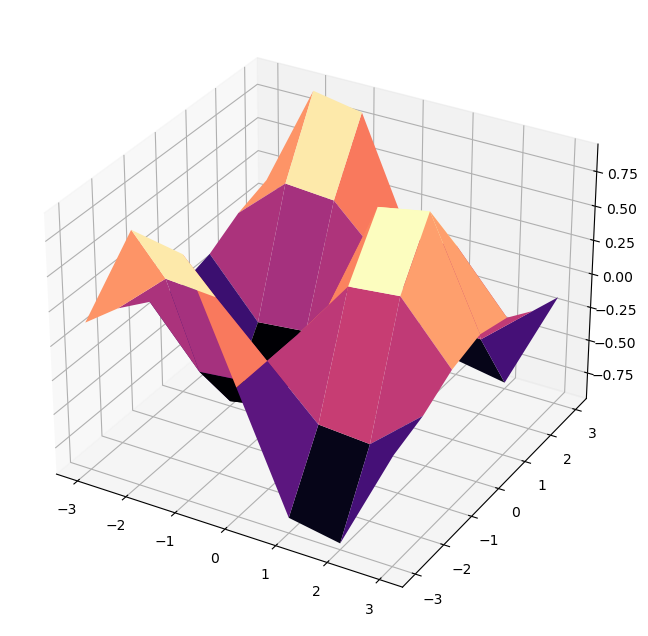

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

f = lambda x, y: np.sin(x) * np.cos(y)
# x = np.linspace(-3, 3, 100)
# y = np.linspace(-3, 3, 100)
x = np.arange(-3, 4)
y = np.arange(-3, 4)
X, Y = np.meshgrid(x, y)
F = f(X, Y)

fig = plt.figure(figsize=[12,8])
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, F, cmap='magma')
plt.show()

In [12]:
print(X.shape)
print(Y.shape)
print(F.shape)

(100, 100)
(100, 100)
(100, 100)


/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_27271/4119747240.py:32: MatplotlibDeprecationWarning:

Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().



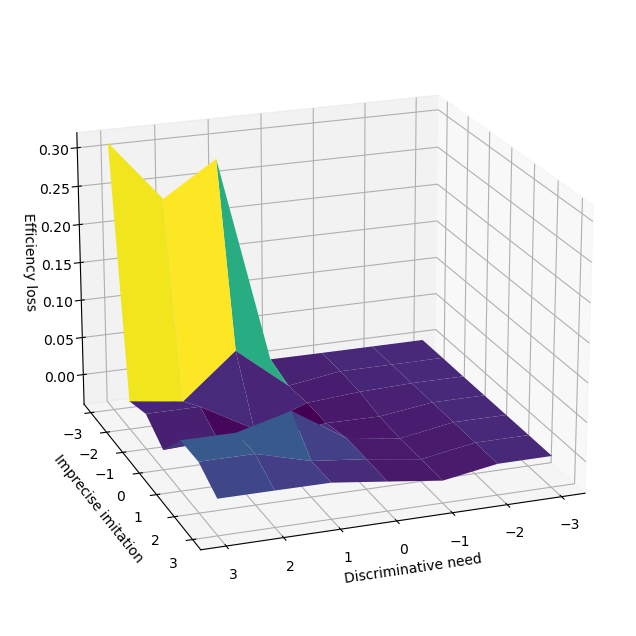

In [74]:
def lookup_efficiency(discr_need: int, imprecision: int) -> float:
    df_discr = df_final_points[df_final_points["discriminative_need_gamma"] == discr_need]
    df_imprecision = df_discr[df_discr["imprecise_imitation_gamma"] == imprecision]
    # need to fix population init
    df_result = df_imprecision[df_imprecision["population_init_gamma"] == 0.]
    eps = float(df_result["eps"].tolist()[0]) # return singleton
    return eps

x = np.arange(-3, 4) # discr_need
y = np.arange(-3, 4) # imprecise imitation

X, Y = np.meshgrid(x, y)

# we need to create the equivalent of matrix elementwise multiplication / conjunction.
# if before we had sin(x) * cos(y),
# this was really
# sin(x_ij) * cos(y_ij) for i in ... for j in ...
# 
# then before our df[...] == x & df[...] == y
# should be df[...] == x_ij & df[...] == y_ij for i in ... for j in ...

# square matrix, so we can just use length
n = len(X)
F = np.array([[lookup_efficiency(
    discr_need=X[i,j], 
    imprecision=Y[i,j],
    ) for i in range(n)] for j in range(n)])


def plotter(E, A):
    fig = plt.figure(figsize=[12,8])
    ax = fig.gca(projection='3d')
    ax.plot_surface(
        X=X, Y=Y, Z=F, 
        cmap="viridis",
    )
    ax.view_init(elev=E, azim=A)
    ax.set_xlabel('Discriminative need')
    ax.set_ylabel('Imprecise imitation')
    ax.set_zlabel('Efficiency loss')
    plt.show()

plotter(20, 70)

In [47]:
# inspect X and Y
X, Y

(array([[-3, -2, -1,  0,  1,  2,  3],
        [-3, -2, -1,  0,  1,  2,  3],
        [-3, -2, -1,  0,  1,  2,  3],
        [-3, -2, -1,  0,  1,  2,  3],
        [-3, -2, -1,  0,  1,  2,  3],
        [-3, -2, -1,  0,  1,  2,  3],
        [-3, -2, -1,  0,  1,  2,  3]]),
 array([[-3, -3, -3, -3, -3, -3, -3],
        [-2, -2, -2, -2, -2, -2, -2],
        [-1, -1, -1, -1, -1, -1, -1],
        [ 0,  0,  0,  0,  0,  0,  0],
        [ 1,  1,  1,  1,  1,  1,  1],
        [ 2,  2,  2,  2,  2,  2,  2],
        [ 3,  3,  3,  3,  3,  3,  3]]))

### Parallel coordinates?

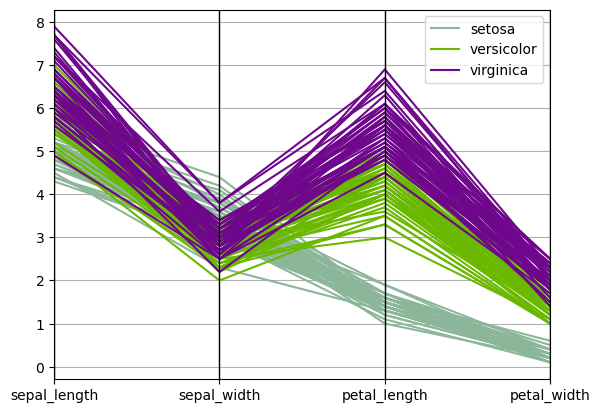

In [79]:
from pandas.plotting import parallel_coordinates

iris = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv')

parallel_coordinates(iris, 'species')
plt.show()


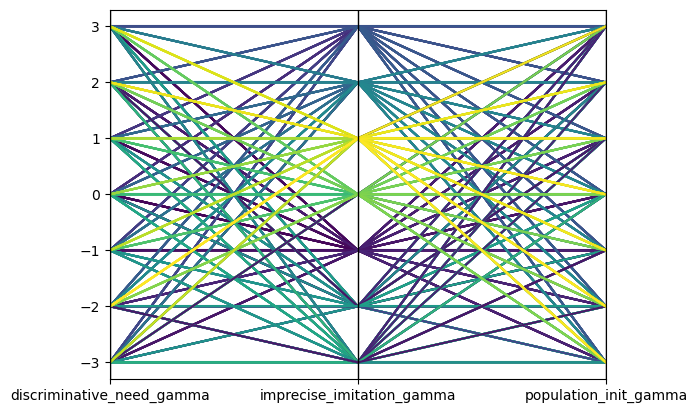

In [117]:
parallel_coordinates(df_final_points[["discriminative_need_gamma", "imprecise_imitation_gamma", "population_init_gamma", "eps"]], 'eps', colormap='viridis')
plt.gca().legend_.remove()
plt.show()


In [85]:
import plotly.express as px
df = px.data.iris()
fig = px.parallel_coordinates(df, color="species_id", labels={"species_id": "Species",
                "sepal_width": "Sepal Width", "sepal_length": "Sepal Length",
                "petal_width": "Petal Width", "petal_length": "Petal Length", },
                             color_continuous_scale=px.colors.diverging.Tealrose,
                             color_continuous_midpoint=2)
fig.show()

In [129]:
import plotly.express as px

# df_pcs = df_final_points[["discriminative_need_gamma", "imprecise_imitation_gamma", "population_init_gamma", "eps"]]

df_final_points["efficiency"] = 1 - df_final_points["eps"] # i don't think F is bounded by one, just need something.

fig = px.parallel_coordinates(
    data_frame=df_final_points[df_final_points["eps"] >= 0.], 
    dimensions=[
        "discriminative_need_gamma",
        "imprecise_imitation_gamma",
        "population_init_gamma",
        ],
    color="eps",
    # color="efficiency",
    labels={
        "discriminative_need_gamma": "Discriminative Need",
        "imprecise_imitation_gamma": "Perceptual Certainty",
        "population_init_gamma": "Initialization Temperature",
        "eps": "Efficiency Loss",
        # "efficiency": "Efficiency",
        },
    # color_continuous_scale='viridis',
    color_continuous_scale=px.colors.diverging.Tealrose,
    color_continuous_midpoint=0.2,
)
fig.show()

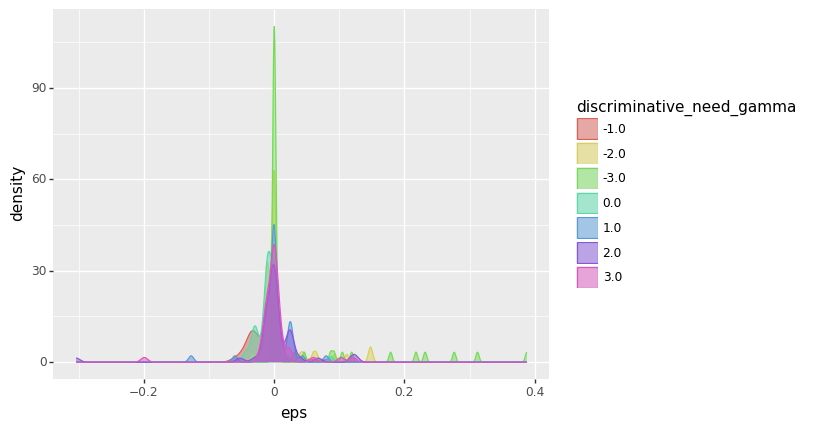

<ggplot: (680877480)>

In [15]:
# Easier: histogram of efficiency.
# efficiency loss = eps
# df = df_final_points[df_final_points["eps"] > 0.]
df = df_final_points.copy()

pressure = "discriminative_need_gamma"
df[pressure] = [ str(item) for item in df[pressure].tolist()]

(
    pn.ggplot(data=df, mapping=pn.aes(x="eps", fill=pressure, color=pressure))
    + pn.geom_density(alpha=0.5)
)